# Day 8 Exercise

### Creating your own recommender engine pool and generating recommendations from a seed track

*A. Individual*
1. Choose your own set of genres to be used as prediction values of the KNN model. You may select among the ones listed above or a completely new one (but you must already have the scraped playlist and tracks data for this new genre) 

2. Choose the features you want to use for the classification. Start by using all and then narrow down by removing one feature at a time and checking if the accuracy increases.

3. Check if the model works by using it to predict genres of the spotify_daily_charts_tracks dataset. Do some spot checks and view the songs classified with the highest probabilities per genre


*B. Groupwork: For your sprint project*

4. Obtain a tracks dataset that is relevant to the client you are targeting. 
   For example:
   
    - A client artist's full discography (hint: use sp.playlist_tracks(ALBUM_ID) for every album of the artist)
    
    - Tracks from a popular playlist in spotify that your client artist appears in
    
    - Discographies of prospect artists to collaborate with 
    
    - Popular tracks of the genre that your client artist is targeting to enter
    
    
5. Using the model you tuned in (A), predict the genres of the tracks in (B.4). 

6. Do some spot checks and view the songs classified with the highest probabilities per genre. 
   What does the predicted classifications reveal about your tracks dataset?
   
*C. Groupwork: For your sprint project*

7. Explore different seed tracks configurations:
    - A single track
    - A *representative track* made by aggregating the audio features and genre probabilities of all tracks in a chosen album/genre
    - A *hypothetical track* with specified desired audio feature values
    
8. For each choice of seed track in, generate using the recommender engine pool you made in (A). As a user, would you listen to the recommended tracks?

9. In addition to (2), check if the top 10 tracks with the **worst** similarity measure (i.e. most dissimilar to the seed track) make sense. As a user, do you agree that these are the tracks to be first discarded from the recommendation pool?



In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Read the training data

In [2]:
genre_names = ["R&B","Jazz", "Pop", "Rock", "Rap"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('./data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('./data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
    
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)


R&B
Jazz
Pop
Rock
Rap


In [3]:
tracks_df['genre'].value_counts()#check shape
playlist_df.shape, tracks_df.shape

((449, 7), (7378, 22))

In [4]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [5]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(6814, 22)

In [6]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(6507, 22)

<AxesSubplot:>

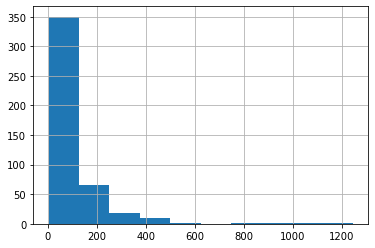

In [7]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

<AxesSubplot:>

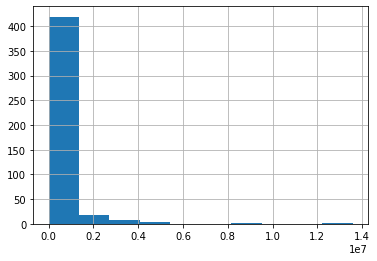

In [8]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [9]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

jazz    0.268326
pop     0.253112
rock    0.217151
rap     0.185493
rnb     0.075918
Name: genre, dtype: float64

### 2. Refine the training data

In [10]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWYmmr74INQlb,I Love My '00s R&B,40,spotify,Spotify,3343023,rnb
1,37i9dQZF1DX6VDO8a6cQME,I Love My '90s R&B,45,spotify,Spotify,2486483,rnb
2,37i9dQZF1DX2UgsUIg75Vg,Chilled R&B,50,spotify,Spotify,2070234,rnb
3,37i9dQZF1DWSfMe9z89s9B,Alternative R&B,100,spotify,Spotify,957270,rnb
4,37i9dQZF1DXbirtHQBuwCo,TrenChill K-R&B,70,spotify,Spotify,535401,rnb


In [11]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

jazz    812
pop     499
rock    468
rnb     286
rap     151
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [12]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [13]:


tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()


count    2216.000000
mean        0.737250
std         0.146425
min         0.000000
25%         0.673964
50%         0.772986
75%         0.839969
max         1.000000
Name: loudness, dtype: float64

In [14]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()


count    2216.000000
mean        0.534397
std         0.140308
min         0.000000
25%         0.419405
50%         0.513106
75%         0.635574
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [15]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [16]:
tracks_df['genre'].value_counts()

jazz    812
pop     499
rock    468
rnb     286
rap     151
Name: genre, dtype: int64

In [17]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
40,0JC3ynTNoZaWjZHXzeapYy,Into You (feat. Fabolous),0le01dl1WllSHhjEXRl4in,Tamia,0WdxQHUdLZBGbscwYV72zM,294093,2004,55,0.677,0.531,...,0.2190,0.00000,0.173,0.570,0.424674,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,4.901550,3
41,2RqZFOLOnzVmHUX7ZMcaES,Let It Go,1vfezMIyCr4XUdYRaKIKi3,Keyshia Cole,7mdy09EO4q6F9VWBtXDDjK,238333,2007-01-01,67,0.806,0.721,...,0.1970,0.00000,0.209,0.781,0.442681,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.972217,3
42,1zpu1PZ8ecmcX525Z3X8cl,Yo (Excuse Me Miss),7bXgB6jMjp9ATFy66eO08Z,Chris Brown,2gRm1k9fVkhTfZDHvBI2sR,229040,2005-11-29,0,0.605,0.633,...,0.1190,0.00000,0.225,0.592,0.406755,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.817333,3
43,4iuNZTcvT9diFySSzVsnVS,When I See U,7xAcVHPiirnUqfdqo0USb1,Fantasia,42DybH3gl3WcfXAQySOEiX,217346,2006-12-09,68,0.569,0.596,...,0.4570,0.00009,0.205,0.757,0.434136,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.622433,3
44,3LmvfNUQtglbTrydsdIqFU,We Belong Together,4iHNK0tOyZPYnBU7nGAgpQ,Mariah Carey,43iBTEWECK7hSnE0p6GgNo,201400,2005-01-01,68,0.837,0.462,...,0.0339,0.00000,0.090,0.762,0.652533,37i9dQZF1DWYmmr74INQlb,rnb,I Love My '00s R&B,3.356667,3


In [18]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{3: 'rnb', 0: 'jazz', 1: 'pop', 4: 'rock', 2: 'rap'}

## 4. Train a KNN model

In [19]:
#test plot for a genre and 2 predictors

# fig = plt.figure()
# ax= fig.add_subplot(111)

# colormaps = ['Reds','Blues']
# genre = 'pop'
# label = ["not "+genre,genre]
# for n,genre_bool in enumerate([0,1]):
#     df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#     sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                 shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                 label=label[n])
    
# plt.legend(frameon=False)


Tuning the model


Tuning kNN classification model with K-Fold=4...
Shape of X_Train:(1772, 9)
Shape of y_Train:(1772,)
Shape of X_Test:(444, 9)
Shape of y_Test:(444,)
Finding best k...


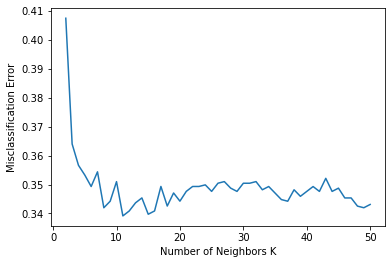

The optimal number of neighbors is 11 with score 66%

Tuning kNN classification model with K-Fold=5...
Shape of X_Train:(1772, 9)
Shape of y_Train:(1772,)
Shape of X_Test:(444, 9)
Shape of y_Test:(444,)
Finding best k...


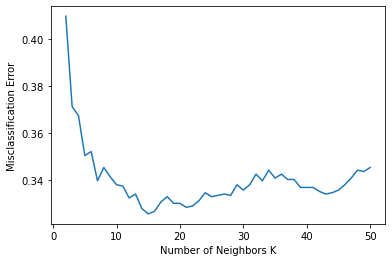

The optimal number of neighbors is 15 with score 67%

Tuning kNN classification model with K-Fold=8...
Shape of X_Train:(1772, 9)
Shape of y_Train:(1772,)
Shape of X_Test:(444, 9)
Shape of y_Test:(444,)
Finding best k...


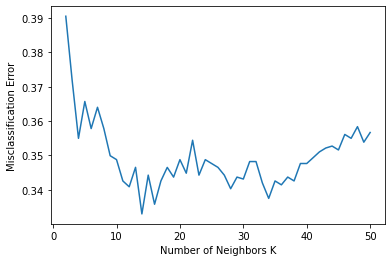

The optimal number of neighbors is 14 with score 66%

Tuning kNN classification model with K-Fold=10...
Shape of X_Train:(1772, 9)
Shape of y_Train:(1772,)
Shape of X_Test:(444, 9)
Shape of y_Test:(444,)
Finding best k...


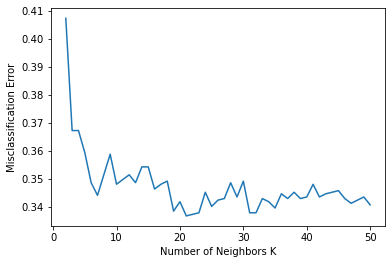

The optimal number of neighbors is 21 with score 66%


In [20]:
#Select audio features to use for the model
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
results_optimal_k = []

kfolds= [4,5,8,10]

for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    print("Shape of X_Train:"+str(X_train.shape))
    print("Shape of y_Train:"+str(Y_train.shape))
    print("Shape of X_Test:"+str(X_test.shape))
    print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=5, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    knn_optimal.fit(X, y)
    # plot misclassification error vs k
    plt.plot(neighbors, mse)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Misclassification Error")
    plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))


In [21]:
results_optimal_k

[11, 15, 14, 21]

### 5. Model Prediction

In [22]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("./data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2.0,-6.209,1.0,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,85,0.358,0.557,10.0,-7.398,1.0,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,85,0.748,0.524,8.0,-5.599,1.0,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,69,0.662,0.586,0.0,-8.821,1.0,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,0,0.783,0.623,7.0,-6.126,1.0,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [23]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [24]:
chart_tracks_df = chart_tracks_df.dropna()
#Predict genres of the spotify charts
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 21


In [25]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,valence,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_jazz_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob
1949,4MmPXbZ5w141AoRUCjYfuF,"214 - Recorded at Kodama Studios, Philippines",6aiCKnIN68hohzU3ZzNq48,Sarah Geronimo,5GpbZxL3X1pOeuY9mBgM8o,276769,2019-02-14,0,0.337,0.126,...,0.131,0.535196,0,jazz,1.0,0.190476,0.047619,0.000000,0.333333,0.428571
2829,25agDEpgr54nRvyQJHmNmR,Di Biro,2M4mQMnLHQQXsFsRmTTqsR,Jana Garcia,2F6OKkFouf9ll5uYQ7myQB,166013,2020-05-22,35,0.595,0.190,...,0.272,0.344909,0,jazz,1.0,1.000000,0.000000,0.000000,0.000000,0.000000
2838,3ByZXP8iXAvhIhkJccDlbD,can’t bear to be without you,0Vw76uk7P8yVtTClWyOhac,HONNE,3DG5MS8iKYcJROCnb1DYDf,150200,2020-07-03,41,0.722,0.767,...,0.310,0.359566,0,jazz,1.0,0.047619,0.380952,0.047619,0.380952,0.142857
2378,3ZCTVFBt2Brf31RLEnCkWJ,everything i wanted,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,4i3rAwPw7Ln2YrKDusaWyT,245425,2019-11-13,85,0.704,0.225,...,0.243,0.414932,0,jazz,1.0,0.047619,0.238095,0.047619,0.619048,0.047619
1833,4PS1e8f2LvuTFgUs1Cn3ON,The Christmas Song (Merry Christmas To You),7v4imS0moSyGdXyLgVTIV7,Nat King Cole,6vBGI5522jvPi0ZZuGQNp4,192160,1962,52,0.319,0.210,...,0.209,0.160745,0,jazz,1.0,0.238095,0.333333,0.000000,0.142857,0.285714


Check out tracks with highest assigned probability

In [26]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
1949,Sarah Geronimo,"214 - Recorded at Kodama Studios, Philippines",jazz,1.000000
2829,Jana Garcia,Di Biro,jazz,1.000000
2838,HONNE,can’t bear to be without you,jazz,1.000000
2378,Billie Eilish,everything i wanted,jazz,1.000000
1833,Nat King Cole,The Christmas Song (Merry Christmas To You),jazz,1.000000
3100,TOMORROW X TOGETHER,Ghosting,rock,0.952381
599,Macklemore,Glorious (feat. Skylar Grey),pop,0.904762
2836,HONNE,loving you is so easy,rock,0.904762
787,Macklemore,Glorious (feat. Skylar Grey),pop,0.904762
129,Bruno Mars,Straight up & Down,rock,0.857143


View histogram of predicted genre probabilities

<AxesSubplot:>

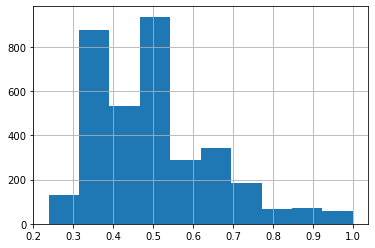

In [27]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [28]:
chart_tracks_df['predicted_genre'].value_counts()

pop     1528
rock     747
jazz     572
rnb      541
rap      101
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [70]:
this_song = 'SONG NAME HERE'
chart_tracks_df[chart_tracks_df['track_name'].str.contains('My Only Wish')]

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_jazz_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob,cosine_dist
620,1UQbxSOVbauPxaUh337GTx,My Only Wish (This Year),26dSoYclwsYLMAKD3tpOr4,Britney Spears,6moGdK0u39XA2UGFrQNml8,255120,2012-11-16,18,0.664,0.741,...,0.581505,4,rock,0.619048,0.047619,0.142857,0.047619,0.047619,0.714286,0.636821
1195,0YWUHZPJVg4iujddsJDwhM,My Only Wish (This Year),26dSoYclwsYLMAKD3tpOr4,Britney Spears,3Hocp9QorapDRHSyZ1AOVL,255400,2000-11-14,44,0.669,0.843,...,0.581523,1,pop,0.523810,0.428571,0.047619,0.047619,0.000000,0.476190,0.669337
1507,7aiVBCp1ibIWE5GeHkbtxr,My Only Wish (This Year),26dSoYclwsYLMAKD3tpOr4,Britney Spears,3O8cHCGgo6phxKJD6j1jnt,255733,2000-11-07,12,0.665,0.844,...,0.581480,4,rock,0.476190,0.142857,0.095238,0.047619,0.000000,0.714286,0.666996
2185,6id0KJ3XgvJLSzyMtHBj67,My Only Wish (This Year),26dSoYclwsYLMAKD3tpOr4,Britney Spears,1hQ9IQJHI5F4LxzdCyR38r,257026,2019-11-13,0,0.666,0.824,...,0.581425,1,pop,0.428571,0.095238,0.333333,0.000000,0.190476,0.380952,0.661837


In [71]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [196]:
#read data
chart_tracks_df=pd.read_csv("./data/spotify_daily_charts_tracks_predicted_genres.csv")
#normalize loudness and tempo
scaler = MinMaxScaler()
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_jazz_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob,cosine_dist
0,4MmPXbZ5w141AoRUCjYfuF,"214 - Recorded at Kodama Studios, Philippines",6aiCKnIN68hohzU3ZzNq48,Sarah Geronimo,5GpbZxL3X1pOeuY9mBgM8o,276769,2019-02-14,0,0.337,0.126,...,0.535196,0,jazz,1.0,0.190476,0.047619,0.000000,0.333333,0.428571,0.583206
1,25agDEpgr54nRvyQJHmNmR,Di Biro,2M4mQMnLHQQXsFsRmTTqsR,Jana Garcia,2F6OKkFouf9ll5uYQ7myQB,166013,2020-05-22,35,0.595,0.190,...,0.344909,0,jazz,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.743367
2,3ByZXP8iXAvhIhkJccDlbD,can’t bear to be without you,0Vw76uk7P8yVtTClWyOhac,HONNE,3DG5MS8iKYcJROCnb1DYDf,150200,2020-07-03,41,0.722,0.767,...,0.359566,0,jazz,1.0,0.047619,0.380952,0.047619,0.380952,0.142857,0.813820
3,3ZCTVFBt2Brf31RLEnCkWJ,everything i wanted,6qqNVTkY8uBg9cP3Jd7DAH,Billie Eilish,4i3rAwPw7Ln2YrKDusaWyT,245425,2019-11-13,85,0.704,0.225,...,0.414932,0,jazz,1.0,0.047619,0.238095,0.047619,0.619048,0.047619,0.728098
4,4PS1e8f2LvuTFgUs1Cn3ON,The Christmas Song (Merry Christmas To You),7v4imS0moSyGdXyLgVTIV7,Nat King Cole,6vBGI5522jvPi0ZZuGQNp4,192160,1962,52,0.319,0.210,...,0.160745,0,jazz,1.0,0.238095,0.333333,0.000000,0.142857,0.285714,0.865368


In [197]:
# Input seed track here
seed_track_name = 'My Only Wish (This Year)'

In [198]:
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

cols = ['track_id','track_name','danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness',\
                'liveness', 'valence', 'tempo']

In [199]:
 seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
 seed_track_data

track_id                  1UQbxSOVbauPxaUh337GTx
track_name              My Only Wish (This Year)
artist_id                 26dSoYclwsYLMAKD3tpOr4
artist_name                       Britney Spears
album_id                  6moGdK0u39XA2UGFrQNml8
duration                                  255120
release_date                          2012-11-16
popularity                                    18
danceability                               0.664
energy                                     0.741
key                                          0.0
loudness                                0.689908
mode                                         1.0
speechiness                               0.0277
acousticness                               0.216
instrumentalness                             0.0
liveness                                   0.235
valence                                    0.669
tempo                                   0.581505
predicted_genre_id                             4
predicted_genre     

In [200]:
seed_track_data[feature_cols]

danceability           0.664
energy                 0.741
loudness            0.689908
speechiness           0.0277
acousticness           0.216
instrumentalness         0.0
liveness               0.235
valence                0.669
tempo               0.581505
Name: 620, dtype: object

In [201]:
#seed_track_data = pd.read_csv('./data/Britney Spears_playlist_tracks_data.csv')
#seed_track_data = seed_track_data[feature_cols].iloc[1]
#seed_track_data = seed_track_data[feature_cols].iloc[1]

seed_track_df_raw = pd.read_csv('./data/Britney Spears_playlist_tracks_data.csv')

seed_track_data.head()


track_id         1UQbxSOVbauPxaUh337GTx
track_name     My Only Wish (This Year)
artist_id        26dSoYclwsYLMAKD3tpOr4
artist_name              Britney Spears
album_id         6moGdK0u39XA2UGFrQNml8
Name: 620, dtype: object

In [202]:
seed_track_data_B = seed_track_df_raw[cols].iloc[1]
seed_track_data_B

track_id            1UI0l2L66HJ9AtoEOlHzv4
track_name                       Sometimes
danceability                         0.745
energy                               0.742
loudness                            -5.693
speechiness                         0.0259
acousticness                          0.42
instrumentalness                       0.0
liveness                             0.102
valence                              0.806
tempo                               95.996
Name: 1, dtype: object

In [203]:
#compute cosine distances, audio features only
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_data_B[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)

chart_tracks_df.sort_values(by='cosine_dist',ascending=False).head(5)

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,tempo,predicted_genre_id,predicted_genre,predicted_genre_prob,predicted_jazz_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob,cosine_dist
3007,6TbDpqKCksZNJjriFhPum8,Could I Love You Any More (feat. Jason Mraz),2Xr7M6vawpp6zwKOMU7iBU,Reneé Dominique,1LYpuMBu82KpTYr6fALY3G,189500,2019-05-31,62,0.288,0.371,...,0.000000,1,pop,0.333333,0.047619,0.619048,0.000000,0.047619,0.285714,1.027421
2203,0RoA7ObU6phWpqhlC9zH4Z,A Million Dreams,2cQr2KbzdRtIFlfbHGnNsL,Ziv Zaifman,7ayBZIe1FHkNv0T5xFCX6F,269453,2017-12-08,75,0.265,0.312,...,0.013383,4,rock,0.428571,0.047619,0.428571,0.238095,0.095238,0.190476,1.014830
2330,11DnDeWTQuv3GIH0XHT2pl,A Million Dreams,2cQr2KbzdRtIFlfbHGnNsL,Ziv Zaifman,1oqnHxrKI3Gq8MKgAGDtMr,269453,2017-12-08,35,0.265,0.312,...,0.013383,4,rock,0.428571,0.000000,0.523810,0.000000,0.095238,0.380952,1.014830
2631,60VaORSJ5x1D4ZPSc0g2En,Bambi,4ufh0WuMZh6y4Dmdnklvdl,BAEKHYUN,5xOx4mWABbTj0qWyZC4q1p,213053,2021-03-30,74,0.438,0.632,...,0.054628,1,pop,0.380952,0.095238,0.190476,0.000000,0.476190,0.238095,0.984232
1865,306akccFCc6D29uDoBDt7t,Girls Like You,04gDigrS5kc9YWfZHwBETP,Maroon 5,1qvLKCq4Xh355Fq0VswCpH,215229,2017-11-03,0,0.601,0.469,...,0.047896,1,pop,0.476190,0.142857,0.190476,0.047619,0.428571,0.190476,0.983566


In [204]:
#seed_track_data = seed_track_data[cols].iloc[1]
#seed_track_data = seed_track_data[feature_cols].iloc[1]

seed_track_data.head()


track_id         1UQbxSOVbauPxaUh337GTx
track_name     My Only Wish (This Year)
artist_id        26dSoYclwsYLMAKD3tpOr4
artist_name              Britney Spears
album_id         6moGdK0u39XA2UGFrQNml8
Name: 620, dtype: object

In [205]:
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data_B['track_id']].sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
3121,Snowfall on Christmas Eve,The Rossman Ensemble,0.311362,rnb,0.575,0.4110,0.536663,0.0722,0.0251,0.069300,0.0751,0.4620,1.000000
2753,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",Moira Dela Torre,0.345114,rock,0.264,0.2730,0.638649,0.0312,0.5350,0.000000,0.2070,0.3150,0.911930
1864,Demonyo,juan karlos,0.349010,rock,0.415,0.5080,0.617441,0.0363,0.0509,0.016200,0.1030,0.1140,0.837889
486,"Closer You and I - From ""Loving in Tandem""",Michael Pangilinan,0.364969,rock,0.207,0.5350,0.713613,0.0414,0.2010,0.000000,0.3360,0.2640,0.906589
2260,Untouchable (Taylor’s Version),Taylor Swift,0.365735,pop,0.393,0.5310,0.742600,0.0329,0.0181,0.000000,0.1690,0.2240,0.909555
2416,Dusk Till Dawn - Radio Edit,ZAYN,0.374941,pop,0.258,0.4370,0.722907,0.0390,0.1010,0.000001,0.1060,0.0967,0.784350
777,Bibingka,Ben&Ben,0.375487,jazz,0.356,0.2290,0.502149,0.0328,0.7970,0.000000,0.1120,0.4310,0.932217
1610,Pray,Sam Smith,0.375558,rock,0.381,0.3790,0.609621,0.0501,0.2920,0.000003,0.0864,0.1530,0.753732
347,The Bells At Christmas,Jose Mari Chan,0.381062,rock,0.227,0.3520,0.572242,0.0321,0.3160,0.000001,0.1290,0.6760,0.856871
35,Can't Help Falling In Love,Kina Grannis,0.381364,jazz,0.266,0.0596,0.234800,0.0363,0.9050,0.000071,0.1320,0.1430,0.794792


In [206]:
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\
                                    [chart_tracks_df['track_id']!=seed_track_data['track_id']]\
                                    .sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

<ipython-input-206-3525b1bc5e04>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recommendation_df = chart_tracks_df[chart_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\


,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
2753,"Kahit Maputi Na Ang Buhok ko - From ""The Hows ...",Moira Dela Torre,0.345114,rock,0.264,0.273,0.638649,0.0312,0.53500,0.000000,0.2070,0.315,0.911930
1864,Demonyo,juan karlos,0.349010,rock,0.415,0.508,0.617441,0.0363,0.05090,0.016200,0.1030,0.114,0.837889
486,"Closer You and I - From ""Loving in Tandem""",Michael Pangilinan,0.364969,rock,0.207,0.535,0.713613,0.0414,0.20100,0.000000,0.3360,0.264,0.906589
1610,Pray,Sam Smith,0.375558,rock,0.381,0.379,0.609621,0.0501,0.29200,0.000003,0.0864,0.153,0.753732
347,The Bells At Christmas,Jose Mari Chan,0.381062,rock,0.227,0.352,0.572242,0.0321,0.31600,0.000001,0.1290,0.676,0.856871
1880,The Good Side,Troye Sivan,0.382246,rock,0.424,0.259,0.316929,0.0531,0.41800,0.002470,0.3540,0.316,0.696434
1079,Sa Susunod na Habang Buhay,Ben&Ben,0.392417,rock,0.311,0.342,0.628905,0.0320,0.43200,0.000002,0.1140,0.274,0.766598
1389,This Is Me,Keala Settle,0.393808,rock,0.284,0.704,0.694944,0.1860,0.00583,0.000115,0.0424,0.100,0.856090
799,Tightrope,Michelle Williams,0.398063,rock,0.351,0.331,0.570481,0.0382,0.30000,0.000009,0.0919,0.191,0.670646
2395,"How Far I'll Go - From ""Moana""",Alessia Cara,0.398110,rock,0.314,0.555,0.599754,0.3700,0.15700,0.000108,0.0670,0.159,0.782030


In [208]:
chart_tracks_df.columns, seed_track_data.index

(Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
        'duration', 'release_date', 'popularity', 'danceability', 'energy',
        'key', 'loudness', 'mode', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo',
        'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
        'predicted_jazz_prob', 'predicted_pop_prob', 'predicted_rap_prob',
        'predicted_rnb_prob', 'predicted_rock_prob', 'cosine_dist'],
       dtype='object'),
 Index(['track_id', 'track_name', 'artist_id', 'artist_name', 'album_id',
        'duration', 'release_date', 'popularity', 'danceability', 'energy',
        'key', 'loudness', 'mode', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo',
        'predicted_genre_id', 'predicted_genre', 'predicted_genre_prob',
        'predicted_jazz_prob', 'predicted_pop_prob', 'predicted_rap_prob',
        'predicted_rnb_prob', 'predicted_rock_prob', 'cosin

In [209]:
chart_tracks_df = chart_tracks_df.dropna()
#Audio features + predicted genre probabilities
genre_cols = [col for col in chart_tracks_df.columns if ('predicted_' in col)&('genre' not in col)]
cols = feature_cols + genre_cols
chart_tracks_df['cosine_dist_mod'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[cols].values.reshape(1, -1),\
                                                                  seed_track_data[cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']]\
                                   .sort_values('cosine_dist_mod')[:10]
recommendation_df[['track_name','artist_name','cosine_dist_mod','predicted_genre']+cols]

,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,predicted_jazz_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob
1507,My Only Wish (This Year),Britney Spears,0.006076,rock,0.665,0.844,0.838199,0.0273,0.17100,0.000000,0.2250,0.665,0.581480,0.142857,0.095238,0.047619,0.000000,0.714286
1818,Copines,Aya Nakamura,0.010643,rock,0.701,0.787,0.831484,0.0855,0.27000,0.000000,0.1050,0.904,0.784252,0.095238,0.142857,0.000000,0.000000,0.761905
1645,Are You Bored Yet? (feat. Clairo),Wallows,0.011355,rnb,0.682,0.683,0.729007,0.0287,0.15600,0.000023,0.2730,0.640,0.415037,0.000000,0.285714,0.000000,0.000000,0.714286
346,Sabi Nang Sabi,ALLMO$T,0.011872,rock,0.613,0.671,0.699324,0.0488,0.22400,0.000000,0.1010,0.697,0.600475,0.095238,0.095238,0.047619,0.190476,0.571429
3338,Savage Love (Laxed – Siren Beat) [BTS Remix],Jawsh 685,0.014117,rnb,0.758,0.598,0.759672,0.0868,0.16000,0.000000,0.2950,0.658,0.598481,0.095238,0.190476,0.000000,0.142857,0.571429
257,Calling All My Lovelies,Bruno Mars,0.015236,rock,0.662,0.705,0.724258,0.0399,0.03920,0.000002,0.1050,0.865,0.660998,0.095238,0.095238,0.000000,0.047619,0.761905
580,Light My Body Up (feat. Nicki Minaj & Lil Wayne),David Guetta,0.015332,rock,0.699,0.660,0.705711,0.0861,0.00365,0.000000,0.1390,0.689,0.574490,0.095238,0.238095,0.000000,0.047619,0.619048
191,Stitches,Shawn Mendes,0.015560,rock,0.746,0.754,0.719304,0.0670,0.01520,0.000000,0.0486,0.764,0.598764,0.047619,0.142857,0.000000,0.000000,0.809524
761,Boy With Luv (feat. Halsey),BTS,0.015926,pop,0.645,0.862,0.798076,0.0965,0.09230,0.000000,0.1920,0.798,0.414840,0.000000,0.238095,0.000000,0.047619,0.714286
512,The Nights,Avicii,0.017523,rock,0.527,0.835,0.775926,0.0433,0.01660,0.000000,0.2490,0.654,0.451710,0.047619,0.190476,0.000000,0.000000,0.761905
